# Modeling Employee Attrition: Feature Engineering & Model Preparation

In this section, we perform key preprocessing steps to prepare our data for predictive modeling. We engineer features that capture relevant patterns and remove those that may introduce noise or data leakage. The final cleaned dataset will be saved for modeling.

In [1]:
# Initial setup
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("../data/ibm_attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Dropping Irrelevant or Leakage Columns

Some columns provide no variability (e.g., `EmployeeCount`, `Over18`) or act as identifiers (`EmployeeNumber`). Others, like `StandardHours`, are constant for all employees. These are dropped to reduce dimensionality and prevent potential data leakage.

In [2]:
# Drop irrelevant columns
drop_cols = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
df.drop(columns=drop_cols, inplace=True)

## Encoding Target Variable

We convert the target variable `Attrition` from categorical (`Yes`, `No`) to binary (`1`, `0`) to make it usable for machine learning models.

In [3]:
# Encode target variable
# Convert 'Attrition' into binary
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

## Encoding Categorical Features

We apply label encoding to categorical variables. Label encoding is efficient for tree-based models like Random Forests and XGBoost. 

In [4]:
# Encode categorical variables
# Identify categorical features
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Use LabelEncoder for simplicity (can swap with OneHot if needed)
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

## Scaling Numeric Features

We scale continuous features using standardization (z-score) to ensure features are on the same scale — important for distance-based algorithms and improving convergence speed in gradient-based models.

In [5]:
# Standardize numerical features
num_cols = df.select_dtypes(include=['int64', 'float64']).drop('Attrition', axis=1).columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

## Correlation with Attrition

To get an early look at which features are most related to employee attrition, we plot the correlation of each feature with the target variable.

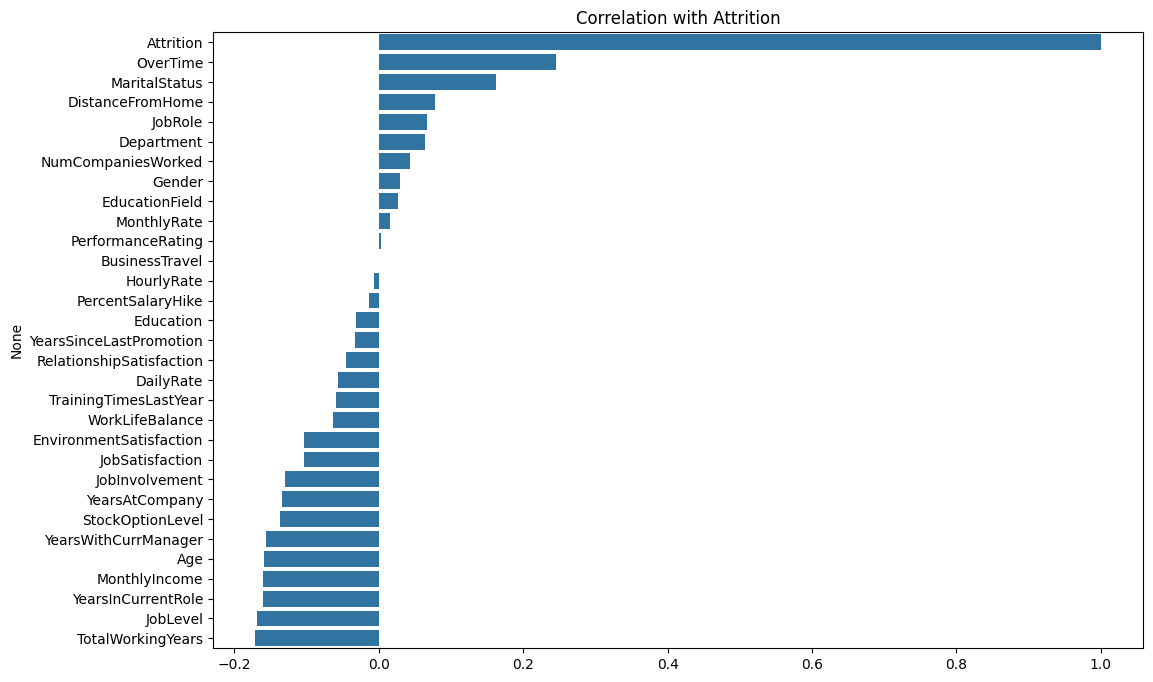

In [6]:
# Visualize feature correlation with Attrition
plt.figure(figsize=(12, 8))
corr = df.corr()['Attrition'].sort_values(ascending=False)
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation with Attrition")
plt.show()

## Save Processed Data

We now save the cleaned and feature-engineered dataset to be used in modeling.

In [7]:
df.to_csv("../data/processed_attrition.csv", index = False)

# Baseline Model: Logistic Regression

To establish a performance benchmark, we begin with a simple Logistic Regression model. This will help us compare the value added by more complex models later. We'll evaluate model performance using accuracy, precision, recall, F1-score, and ROC-AUC.

## Splitting Data

We split the dataset into training and test sets using a stratified split to preserve the attrition rate in both sets.

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='Attrition')
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=5
)

## Training Logistic Regression Model

In [9]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=5)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=5)

## Model Evaluation on Test Set

We evaluate the model using classification metrics and ROC-AUC to understand how well it distinguishes between employees who leave and those who stay.

In [10]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix
)

y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.2f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       247
           1       0.66      0.40      0.50        47

    accuracy                           0.87       294
   macro avg       0.77      0.68      0.71       294
weighted avg       0.86      0.87      0.86       294

Confusion Matrix:

[[237  10]
 [ 28  19]]
Accuracy: 0.87
Precision: 0.66
Recall: 0.40
F1 Score: 0.50
ROC AUC: 0.78


### Baseline Model Evaluation Insights

- The model achieved a strong **overall accuracy of 87%**, which may seem promising at first glance.
- However, imbalance is still evident; **the model performs much better at predicting employees who did not leave (class 0) than those who did (class 1)**.
    - For class 0: Precision = 0.89, Recall = 0.96, F1 = 0.93
    - For class 1: Precision = 0.66, Recall = 0.40, F1 = 0.50
- The recall for class 1 (employees who left) is only 40%, meaning **the model misses more than half of the employees who actually left.**
- The ROC AUC of 0.78 indicates moderate discriminative ability but shows room for improvement.
- The confusion matrix highlights that **28 out of 47 attrition cases were misclassified, which could be critical in a real-world HR setting where proactive intervention is needed.**

### Next Steps

1. **Address Class Imbalance:** Try SMOTE or class weighting techniques to boost minority class recall. ```class_weight='balanced'```
2. **Revisit Feature Selection & Engineering:** Revisit feature importane to identify top predictive variables. Possibly create new features like tenure buckets, interaction terms, or simplified categories. 
3. **Model Improvements** Test tree based models like random forest, XGBoost/LightGBM, or Gradient Boosting Classifier
4. **Hyperparameter Tuning** Try model optimization using GridSearchCV or RandomizedSearchCV.
5. **Prioritize the most relevant metrics** High overall accuracy is important, but correctly identifying employees who are likely to leave the company is essential in this HR context, so HR representatives may take proactive steps to prevent attrition. 